In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import allel
from os.path import join
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import admix
from scipy import stats
from functools import reduce
from utils import impute_dataset, marginal
from IPython.display import display, Markdown, Latex

import myvariant
mv = myvariant.MyVariantInfo()

def get_rsid(snp):
    fields = snp.split(":")
    snp = fields[0] + ":" + "g." + fields[1] + fields[2] + ">" + fields[3]
    return mv.getvariant(snp, assembly='hg38', fields="dbsnp.rsid")["dbsnp"]["rsid"]

def pval2zsc(pval):
    return -stats.norm.ppf(pval)

col_trait = ["cholesterol", "ldl_direct"]
col_cov = ["AGE", "SEX", "dilution_factor"] + [f"PC{i + 1}" for i in range(10)]

In [2]:
for trait in ["cholesterol", "ldl_direct"]:
    print(trait + ":")
    
#     # validate with PLINK
#     plink_assoc = []
#     for i_chr in range(1, 23):
#         plink_assoc.append(pd.read_csv(f"04_assoc/plink_assoc/{trait}.{i_chr}.assoc.linear", delim_whitespace=True))
#     plink_assoc = pd.concat(plink_assoc, axis=0)

    assoc = []
    for i_chr in range(1, 23):
        assoc.append(pd.read_csv(f"04_assoc/assoc/{trait}.chr{i_chr}.csv"))
    assoc = pd.concat(assoc, axis=0)

#     fig, ax = plt.subplots(dpi=150, figsize=(3, 3))
#     plt.scatter(-np.log10(plink_assoc.P), -np.log10(assoc.ATT), s=1., )
#     plt.axline((0, 0), slope=1, color='k', ls='--')

    for method in ["ATT", "SNP1", "TRACTOR"]:
        chisq = pval2zsc(assoc[method]) ** 2
        print(f"lambda_gc for {method} : {np.quantile(chisq, 0.5) / stats.chi2.ppf(0.5, 1): .3f}")

cholesterol:
lambda_gc for ATT :  1.013
lambda_gc for SNP1 :  1.008
lambda_gc for TRACTOR :  1.072
ldl_direct:
lambda_gc for ATT :  1.008
lambda_gc for SNP1 :  1.009
lambda_gc for TRACTOR :  1.076


# Association testing

In [3]:
window_size = 50_000
dict_region = {
    "APOE": [19, 44905796, 44909393],
    "LDLR": [19, 11089432, 11133820],
    "PCSK9": [1, 55039548, 55064852],
    "SORT1":  [1, 109309574, 109397939]
}

dict_ds_imputed = dict()

for gene in dict_region:
    region = dict_region[gene]
    gene_chr, gene_start, gene_stop = region
    region_text = f"chr{gene_chr}:{gene_start - window_size}-{gene_stop + window_size}"
    ds = xr.open_zarr(f"04_assoc/dataset/chr{gene_chr}.zarr", chunks=None)
    path_imputed = f"02_impute/processed/chr{gene_chr}/chr{gene_chr}.sample.imputed.vcf.gz"
    vcf = allel.read_vcf(path_imputed, region=region_text)

    ds_imputed = impute_dataset(vcf, ds)

    region_snp = ds.snp[(gene_start - window_size < ds.position) & (ds.position < gene_stop + window_size)]
    ds_subset = ds.sel(snp=region_snp)
    assert (ds_imputed.sel(snp=ds_subset.snp).lanc == ds_subset.lanc).all()
    
    for col_trait in ["cholesterol", "ldl_direct"]:
        
        region_att = marginal(ds_imputed, col_pheno=col_trait, col_cov=col_cov, method="ATT")
        region_snp1 = marginal(ds_imputed, col_pheno=col_trait, col_cov=col_cov, method="SNP1")
        region_tractor = marginal(ds_imputed, col_pheno=col_trait, col_cov=col_cov, method="TRACTOR")
        region_adm = marginal(ds_imputed, col_pheno=col_trait, col_cov=col_cov, method="ADM")
        
        ds_imputed = ds_imputed.assign_coords({
            f"assoc_{col_trait}_att": ("snp", region_att.P.values),
            f"assoc_{col_trait}_snp1": ("snp", region_snp1.P.values),
            f"assoc_{col_trait}_tractor": ("snp", region_tractor.P.values),
            f"assoc_{col_trait}_adm": ("snp", region_adm.P.values),
        })
    dict_ds_imputed[gene] = ds_imputed


100%|██████████| 816/816 [00:09<00:00, 85.82it/s]


# APOE; cholesterol

findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeOneSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeTwoSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeThreeSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeFourSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeFiveSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found

trait: cholesterol, rsid: rs7412, att: 2.28e-31, snp1: 4.70e-31, tractor: 1.22e-29


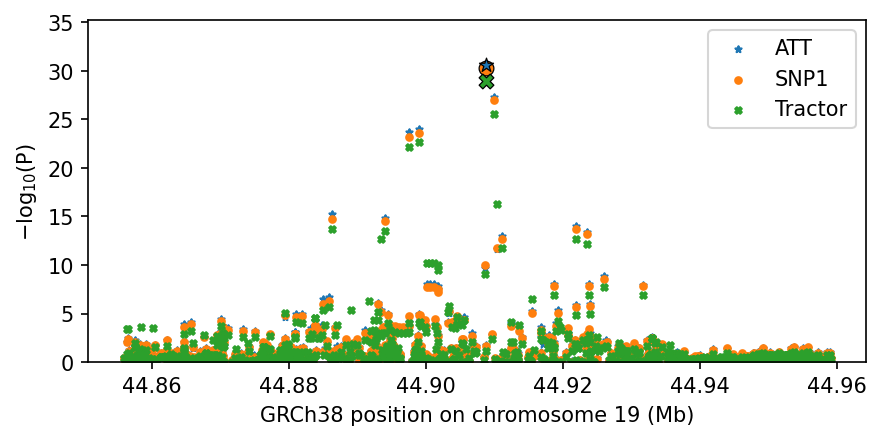

# APOE; ldl_direct

trait: ldl_direct, rsid: rs7412, att: 9.09e-51, snp1: 1.56e-50, tractor: 3.22e-48


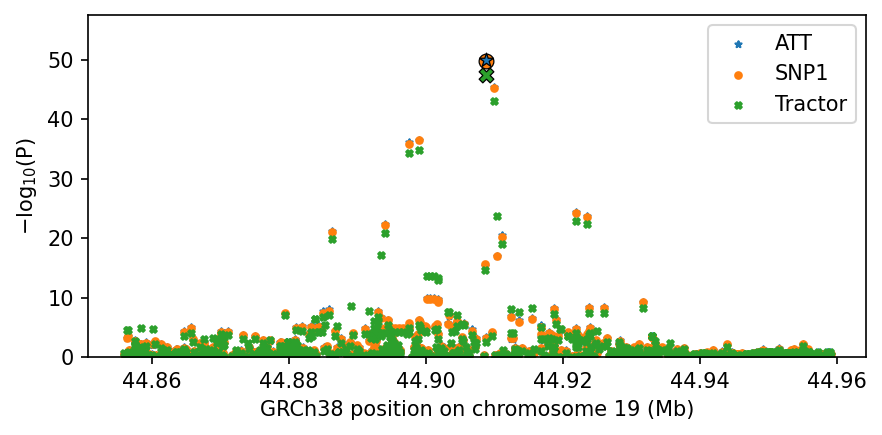

# LDLR; cholesterol

trait: cholesterol, rsid: rs138294113, att: 5.59e-09, snp1: 6.58e-09, tractor: 2.78e-08


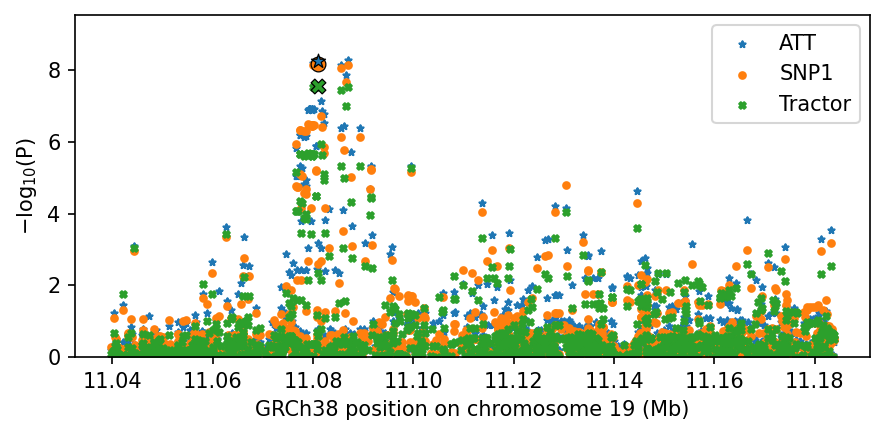

# LDLR; ldl_direct

trait: ldl_direct, rsid: rs138294113, att: 2.30e-10, snp1: 2.76e-10, tractor: 1.65e-09


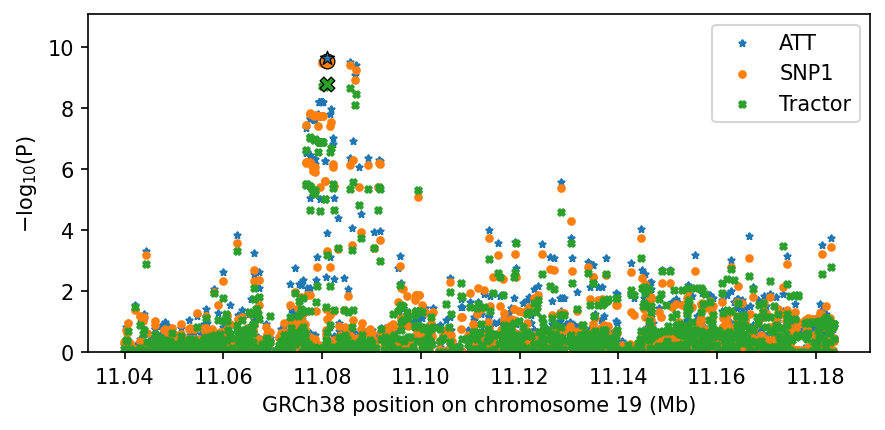

# PCSK9; cholesterol

trait: cholesterol, rsid: rs11804420, att: 4.02e-10, snp1: 3.43e-09, tractor: 2.09e-08


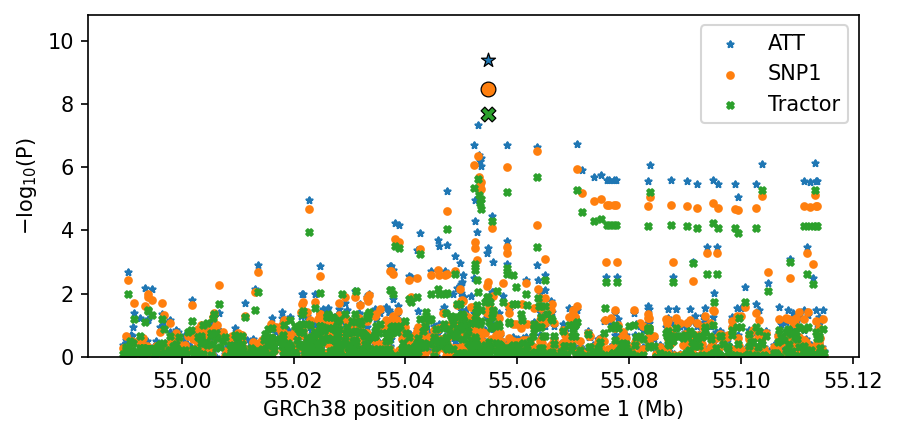

# PCSK9; ldl_direct

trait: ldl_direct, rsid: rs28362286, att: 2.66e-10, snp1: 3.56e-10, tractor: 2.92e-09


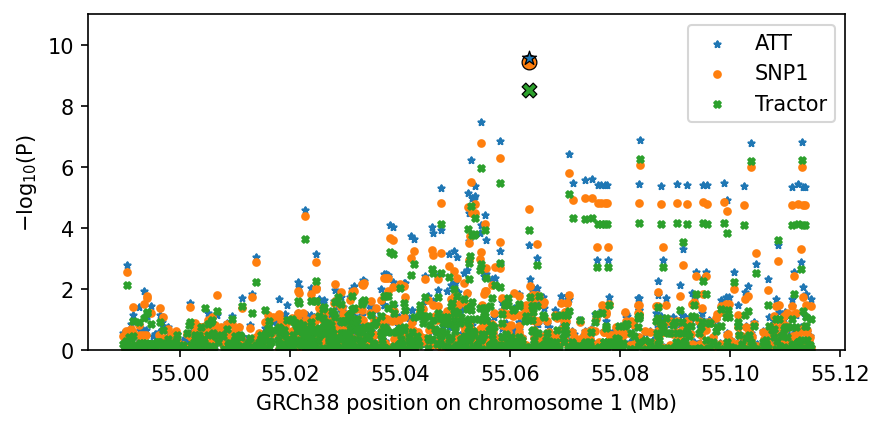

# SORT1; cholesterol

trait: cholesterol, rsid: rs7528419, att: 8.26e-06, snp1: 9.21e-06, tractor: 5.17e-05


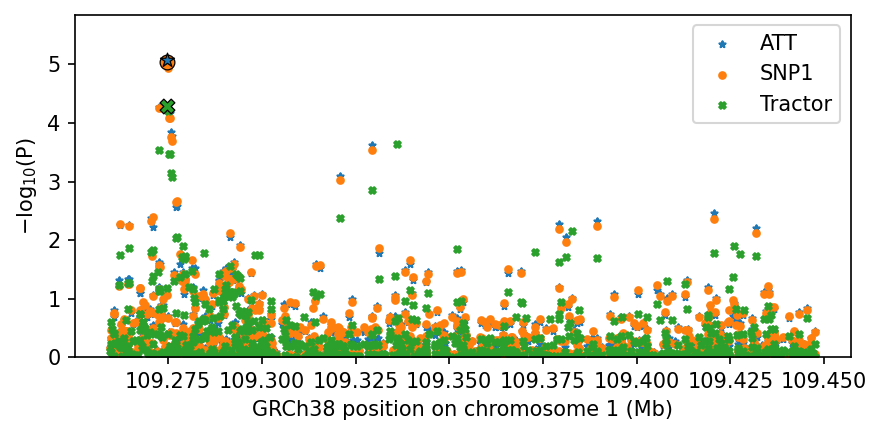

# SORT1; ldl_direct

trait: ldl_direct, rsid: rs12740374, att: 7.64e-08, snp1: 8.27e-08, tractor: 5.22e-07


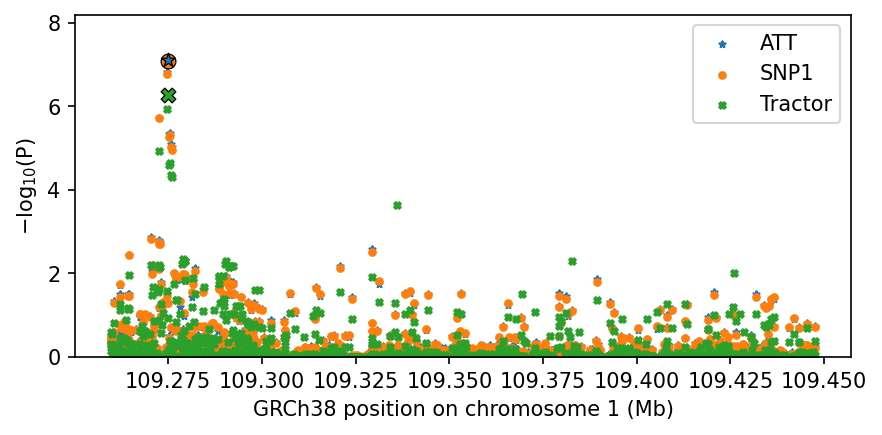

In [4]:
cycle_colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
cycle_markers = ['*', 'o', 'X']

df_pval = {
    "trait": [],
    "loci": [],
    "att": [],
    "snp1": [],
    "tractor": []
}

for gene in dict_region:
    region = dict_region[gene]
    ds_imputed = dict_ds_imputed[gene]
    position = ds_imputed.position.values / 1e6
    for trait in ["cholesterol", "ldl_direct"]:
        display(Markdown(f"# {gene}; {trait}"))
        ylim = 0
        assoc_att, assoc_snp1, assoc_tractor = ds_imputed[f"assoc_{trait}_att"].values, ds_imputed[f"assoc_{trait}_snp1"].values, ds_imputed[f"assoc_{trait}_tractor"].values
        fig, ax = plt.subplots(dpi=150, figsize=(6, 3))
        
        legends = []
        for i, (label, pval) in enumerate(zip(["ATT", "SNP1", "Tractor"], 
                                               [assoc_att, assoc_snp1, assoc_tractor])):
            
            score = -np.log10(pval)
            ax.scatter(position, score, alpha=1.0, s=10.0, label=label, color=cycle_colors[i], marker=cycle_markers[i])
            # adjust y limit
            ylim = max(max(score), ylim)
        ax.set_xlabel(f"GRCh38 position on chromosome {region[0]} (Mb)")
        ax.set_ylabel("$-\log_{10}(P)$")
        
        # select index SNP based on strongest p-values from tractor, to have a conservative comparison.
        index = assoc_tractor.argmin()
        rsid = get_rsid(ds_imputed.snp[index].values.item())
        print(f"trait: {trait}, rsid: {rsid}, att: {assoc_att[index]:.2e}, snp1: {assoc_snp1[index]:.2e}, tractor: {assoc_tractor[index]:.2e}")
#         ax.annotate(gene + ":" + rsid, xy=(position[index], -np.log10(assoc_att[index]) * 1.03), ha="center")
        
        for i, pval in enumerate([assoc_att, assoc_snp1, assoc_tractor]):
            zorder = 10 if i == 0 else 1
            score = -np.log10(pval)
            ax.scatter(position[index], score[index], alpha=1.0, s=50.0, color=cycle_colors[i], edgecolors='k', linewidths=0.6, marker=cycle_markers[i], zorder=zorder)
        
        plt.legend()
        plt.tight_layout()
        plt.ylim(0, ylim * 1.15)
        plt.savefig(f"results/locus_{gene}_{trait}.png", bbox_inches='tight')
        plt.show()
    
        df_pval["trait"].append(trait)
        df_pval["loci"].append(gene)
        df_pval["att"].append(assoc_att[index])
        df_pval["snp1"].append(assoc_snp1[index])
        df_pval["tractor"].append(assoc_tractor[index])
        
        # ADM region plot
#         fig, ax = plt.subplots(dpi=150, figsize=(6, 3))
#         assoc_adm = ds_imputed[f"assoc_{trait}_adm"].values
#         ax.scatter(position, -np.log10(assoc_adm), alpha=1.0, s=9.0, label="ADM")
#         ax.set_xlabel(f"GRCh38 position on chromosome {region[0]} (Mb)")
#         ax.set_ylabel("$-\log_{10}(p_{ADM})$")
#         plt.show()

df_pval = pd.DataFrame(df_pval)

In [5]:
df_pval_fmt = df_pval.replace({"ldl_direct": "LDL", "cholesterol": "TC", "hdl_cholesterol": "HDL"})
df_pval_fmt.columns = ["Trait", "Locus", "ATT", "SNP1", "Tractor"]

df_log10pval_fmt = df_pval_fmt.copy()
df_log10pval_fmt[["ATT", "SNP1", "Tractor"]] = -np.log10(df_log10pval_fmt[["ATT", "SNP1", "Tractor"]])

for method in ["SNP1", "Tractor"]:
    df_rel = (df_log10pval_fmt[method] - df_log10pval_fmt["ATT"]) / df_log10pval_fmt["ATT"] * 100
    df_log10pval_fmt[method] = df_log10pval_fmt[method].round(1).astype(str) + " (" + df_rel.round(1).astype(str) + "%)"
    print(f"-log10(p): {method} relative to ATT, average {df_rel.mean():.1f}%")
df_log10pval_fmt["ATT"] = df_log10pval_fmt["ATT"].round(1).astype(str)

df_chi2_fmt = df_pval_fmt.copy()
df_chi2_fmt[["ATT", "SNP1", "Tractor"]] = pval2zsc(df_chi2_fmt[["ATT", "SNP1", "Tractor"]]) ** 2

for method in ["SNP1", "Tractor"]:
    df_rel = (df_chi2_fmt[method] - df_chi2_fmt["ATT"]) / df_chi2_fmt["ATT"] * 100
    df_chi2_fmt[method] = df_chi2_fmt[method].round(1).astype(str) + " (" + df_rel.round(1).astype(str) + "%)"
    print(f"chi2: {method} relative to ATT, average {df_rel.mean():.1f}%")
df_chi2_fmt["ATT"] = df_chi2_fmt["ATT"].round(1).astype(str)

-log10(p): SNP1 relative to ATT, average -2.0%
-log10(p): Tractor relative to ATT, average -10.6%
chi2: SNP1 relative to ATT, average -2.2%
chi2: Tractor relative to ATT, average -11.9%


In [6]:
writer = pd.ExcelWriter('results/risk_region.xlsx', engine='xlsxwriter')
df_log10pval_fmt.to_excel(writer, index=False, sheet_name="-log10p")
df_chi2_fmt.to_excel(writer, index=False, sheet_name="chi2")
writer.save()